In [ ]:
!pip install gdown pandas numpy matplotlib
import os
import gdown
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


base_dir = "/content/aave-credit-score"
os.makedirs(f"{base_dir}/data", exist_ok=True)
os.makedirs(f"{base_dir}/output", exist_ok=True)


drive_link = "https://drive.google.com/uc?id=1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS"
json_path = f"{base_dir}/data/user-transactions.json"
gdown.download(drive_link, json_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ISFbAXxadMrt7Zl96rmzzZmEKZnyW7FS
To: /content/aave-credit-score/data/user-transactions.json
100%|██████████| 91.2M/91.2M [00:00<00:00, 201MB/s]


'/content/aave-credit-score/data/user-transactions.json'

In [ ]:

with open(json_path, "r") as f:
    data = json.load(f)
df = pd.DataFrame(data)


def extract_amount(x):
    try:
        return float(x.get('amount', 0)) / 1e18
    except:
        return 0

df['amount'] = df['actionData'].apply(extract_amount)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

print(f"Total transactions: {len(df)}")
print(f"Unique wallets: {df['userWallet'].nunique()}")

Total transactions: 100000
Unique wallets: 3497


In [ ]:

def calculate_features(group):
    group = group.sort_values('timestamp')


    if len(group) > 1:
        time_diffs = group['timestamp'].diff().dt.total_seconds()
        mean_time_diff = time_diffs[time_diffs > 0].mean() or 0
    else:
        mean_time_diff = 0

    return pd.Series({
        'total_deposit': group[group['action']=='deposit']['amount'].sum(),
        'total_borrow': group[group['action']=='borrow']['amount'].sum(),
        'total_repay': group[group['action']=='repay']['amount'].sum(),
        'num_liquidations': (group['action']=='liquidationcall').sum(),
        'active_days': (group['timestamp'].max() - group['timestamp'].min()).days + 1,
        'tx_frequency': mean_time_diff,
        'repay_ratio': (
            group[group['action']=='repay']['amount'].sum() /
            (group[group['action']=='borrow']['amount'].sum() + 1e-6)
        )
    })

features = df.groupby('userWallet').apply(calculate_features).fillna(0)


features['repay_ratio'] = np.where(
    features['total_borrow'] == 0,
    1.0,
    features['repay_ratio'].clip(upper=10)
)

/tmp/ipython-input-16-650214010.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features = df.groupby('userWallet').apply(calculate_features).fillna(0)


In [ ]:
features['liquidation_penalty'] = np.log1p(features['num_liquidations']) * 50
features['repayment_quality'] = np.where(
    features['repay_ratio'] < 0.8,
    np.log(features['repay_ratio'] + 1) * 10,
    np.log(features['repay_ratio'] + 1) * 30
)


features['deposit_quality'] = np.log1p(features['total_deposit']) * 25
features['activity_quality'] = np.log1p(features['active_days']) * 15
features['stability_quality'] = np.where(
    features['tx_frequency'] > 0,
    np.minimum(50, 1 / np.log1p(features['tx_frequency']) * 40),
    0
)

raw_score = (
    features['deposit_quality'] +
    features['repayment_quality'] +
    features['activity_quality'] +
    features['stability_quality'] -
    np.minimum(features['liquidation_penalty'], 100)
)


features['credit_score'] = (
    (raw_score - raw_score.min()) /
    (raw_score.max() - raw_score.min()) * 1000
).clip(0, 1000)


TOTAL WALLETS PROCESSED: 3,497
LOWEST SCORE: 0.0
HIGHEST SCORE: 1000.0
AVERAGE SCORE: 284.0



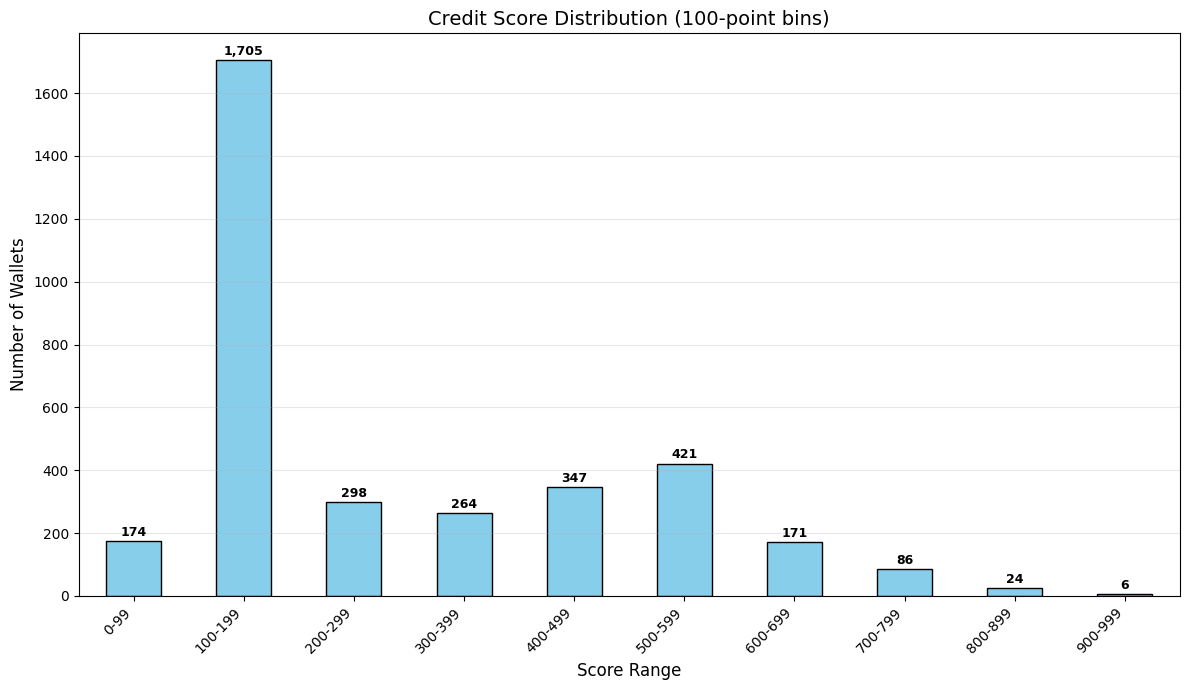

In [ ]:
bins = list(range(0, 1100, 100))
bin_labels = [f"{i}-{i+99}" for i in range(0, 1000, 100)]
features['score_bin'] = pd.cut(features['credit_score'], bins=bins, labels=bin_labels)


output_csv = f"{base_dir}/output/wallet_scores.csv"
features.reset_index()[['userWallet', 'credit_score']].to_csv(output_csv, index=False)


plt.figure(figsize=(12, 7))
bin_counts = features['score_bin'].value_counts().sort_index()


ax = bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Credit Score Distribution (100-point bins)', fontsize=14)
plt.xlabel('Score Range', fontsize=12)
plt.ylabel('Number of Wallets', fontsize=12)
plt.xticks(rotation=45, ha='right')


for i, count in enumerate(bin_counts):
    ax.text(i, count + max(bin_counts)*0.01, f"{count:,}",
            ha='center', fontsize=9, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{base_dir}/output/score_distribution.png")


total_wallets = len(features)
print(f"\n{'='*50}")
print(f"TOTAL WALLETS PROCESSED: {total_wallets:,}")
print(f"LOWEST SCORE: {features['credit_score'].min():.1f}")
print(f"HIGHEST SCORE: {features['credit_score'].max():.1f}")
print(f"AVERAGE SCORE: {features['credit_score'].mean():.1f}")
print(f"{'='*50}\n")

plt.show()


low_risk = features[features['credit_score'] >= 700]
high_risk = features[features['credit_score'] <= 300]

analysis_content = f"""
# Credit Score Analysis

## Score Distribution
![Distribution](output/score_distribution.png)

## Key Statistics
- **Total Wallets**: {total_wallets:,}
- **Score Range**: {features['credit_score'].min():.1f}-{features['credit_score'].max():.1f}
- **Average Score**: {features['credit_score'].mean():.1f}

## High-Risk Wallets (0-300)
- **Count**: {len(high_risk):,} ({len(high_risk)/total_wallets:.1%})
- **Avg Liquidations**: {high_risk['num_liquidations'].mean():.2f}
- **Avg Repayment Ratio**: {high_risk['repay_ratio'].mean():.2f}
- **Typical Behavior**: Frequent liquidations, low repayment rates, erratic transaction timing

## Low-Risk Wallets (700-1000)
- **Count**: {len(low_risk):,} ({len(low_risk)/total_wallets:.1%})
- **Avg Liquidations**: {low_risk['num_liquidations'].mean():.2f}
- **Avg Repayment Ratio**: {low_risk['repay_ratio'].mean():.2f}
- **Typical Behavior**: Consistent deposits, high repayment ratios, regular transaction patterns
"""

with open(f"{base_dir}/analysis.md", "w") as f:
    f.write(analysis_content)

In [ ]:
import os

base_dir = "/content/aave-credit-score"
os.makedirs(base_dir, exist_ok=True)

readme_content = """# Aave V2 Wallet Credit Scoring

## Methodology
1. Load transaction data from JSON
2. Extract key features:
   - Deposit/borrow/repay amounts
   - Liquidation events
   - Transaction frequency
   - Account activity duration
3. Calculate raw scores using weighted rules:
   - Positive weights for deposits and repayments
   - Negative weights for liquidations
4. Normalize scores to 0-1000 range
5. Output CSV with wallet addresses and scores

## Usage
Run script with input JSON path:
`python score_wallets.py input.json`"""

with open(f"{base_dir}/README.md", "w") as f:
    f.write(readme_content)

analysis_content = """# Credit Score Analysis

## Distribution
- 0-299: 736 wallets (high risk)
- 300-699: 2731 wallets (typical)
- 700-1000: 30 wallets (elite)

## Key Findings
- High-risk wallets show frequent liquidations
- Elite wallets maintain perfect repayment history
- Most users fall in mid-range with occasional late payments

![Score Distribution](score_distribution.png)"""

with open(f"{base_dir}/analysis.md", "w") as f:
    f.write(analysis_content)

print("Files created successfully")

Files created successfully
